# KFAC for autoencoder

## Headers + common utils

In [1]:
import gzip
import numpy
import numpy as np
import scipy
import sys
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
import time

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()


USE_MKL = True


if USE_MKL:
  assert np.__config__.get_info("lapack_mkl_info"), "No MKL detected :("
  print("Using MKL")

# for line profiling
try:
    profile  # throws an exception when profile isn't defined
except NameError:
    profile = lambda x: x   # if it's not defined simply ignore the decorator.
    

# helper utilities
def W_uniform(s1, s2): # uniform weight init from Ng UFLDL
  r = np.sqrt(6) / np.sqrt(s1 + s2 + 1)
  result = np.random.random(2*s2*s1)*2*r-r
  return result.astype(dtype)

def load_MNIST_images(filename):
  """
  returns a 28x28x[number of MNIST images] matrix containing
  the raw MNIST images
  :param filename: input data file
  """
  with open(filename, "r") as f:
    magic = np.fromfile(f, dtype=np.dtype('>i4'), count=1)

    num_images = int(np.fromfile(f, dtype=np.dtype('>i4'), count=1))
    num_rows = int(np.fromfile(f, dtype=np.dtype('>i4'), count=1))
    num_cols = int(np.fromfile(f, dtype=np.dtype('>i4'), count=1))

    images = np.fromfile(f, dtype=np.ubyte)
    images = images.reshape((num_images, num_rows * num_cols)).transpose()
    images = images.astype(np.float64) / 255

    f.close()

    return images

def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)[0]

def extract_images(f):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
  Args:
    f: A file object that can be passed into a gzip reader.
  Returns:
    data: A 4D uint8 numpy array [index, y, x, depth].
  Raises:
    ValueError: If the bytestream does not start with 2051.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                       (magic, f.name))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data


def t(x):
  return tf.transpose(x)

# TensorShape([Dimension(2), Dimension(10)]) => (2, 10)
def fix_shape(tf_shape):
  return tuple(int(dim) for dim in tf_shape)

def partition_list(l, sizes):
  """Partition l into sublists of given sizes."""
  assert len(l.shape) == 1
  assert np.sum(sizes) == l.shape[0]
  splits = []
  current_idx = 0
  for i in range(len(sizes)):
    splits.append(l[current_idx: current_idx+sizes[i]])
    current_idx += sizes[i]
  return splits

def unflatten(Wf, fs):
  """Turn flattened Tensor into list of rank-2 tensors with given sizes."""
  
  Wf_shape = fix_shape(Wf.shape)
  if len(Wf_shape)==2 and Wf_shape[1] == 1:  # treat col mats as vectors
    Wf = tf.reshape(Wf, [-1])
  dims = [(fs[i+1],fs[i]) for i in range(len(fs)-1)]
  sizes = [s[0]*s[1] for s in dims]
  assert len(Wf.shape) == 1
  assert np.sum(sizes)==Wf.shape[0]
  Wsf = partition_list(Wf, sizes)
  Ws = [unvec(Wsf[i], dims[i][0]) for i in range(len(sizes))]
  return Ws

def unvec(vec, rows):
  """Turn vectorized version of tensor into original matrix with given
  number of rows."""
  assert len(vec.shape) == 1
  assert vec.shape[0]%rows == 0
  cols = int(vec.shape[0]//rows)
  return tf.transpose(tf.reshape(vec, (cols, -1)))


def vec(mat):
  """Vectorize matrix."""
  return tf.reshape(tf.transpose(mat), [-1,1])


def flatten(Ws):
  """Inverse of unflatten."""
  return tf.concat([tf.reshape(vec(W),(-1,)) for W in Ws], axis=0)

def L2(t):
  return tf.reduce_sum(tf.square(t))

def Identity(n):
  """Identity matrix of size n."""
  return tf.diag(tf.ones((n,), dtype=dtype))

def regularized_inverse(mat, lambda_):
  n = int(mat.shape[0])
  assert n == int(mat.shape[1])
  regmat = mat + lambda_*Identity(n)
  if USE_MKL:   # MKL is 5x faster than TF for inverses
    return tf.constant(scipy.linalg.inv(regmat.numpy()))
  return tf.linalg.inv(regmat)

# Time tracking functions
global_time_list = []
global_last_time = 0
def record_time():
  global global_last_time, global_time_list
  new_time = time.perf_counter()
  global_time_list.append(new_time - global_last_time)
  global_last_time = time.perf_counter()

def summarize_time(time_list=None):
  if time_list is None:
    time_list = global_time_list

  if time_list[0]>3600*10:   # large first interval means no relative ts
    del time_list[0]
    
  time_list = 1000*np.array(time_list)  # get seconds, convert to ms
  if len(time_list)>0:
    min = np.min(time_list)
    median = np.median(time_list)
    formatted = ["%.2f"%(d,) for d in time_list[:10]]
    print("Times: min: %.2f, median: %.2f, mean: %.2f"%(min, median, np.mean(time_list)))
    #    print("Times: min: %.2f, median: %.2f, mean: %.2f"%(min, median,",".join(formatted)))
  else:
    print("Times: <empty>")

Using MKL


## Implement KFAC gradient calculation

In [2]:
def loss_and_grad(Wf):
  """Returns cost, gradient for current parameter vector."""
  
  W = unflatten(Wf, fs[1:])   # perftodo: this creates transposes
  W.insert(0, X)

  A = [None]*(n+2)
  A[1] = W[0]
  for i in range(1, n+1):
    A[i+1] = tf.sigmoid(W[i] @ A[i])
  err = (A[3] - A[1])

  def d_sigmoid(y):
    return y*(1-y)

  B = [None]*(n+1)
  B2 = [None]*(n+1)
  B[n] = err*d_sigmoid(A[n+1])
  sampled_labels = tf.random_normal((f(n), f(-1)), dtype=dtype, seed=0)
  B2[n] = sampled_labels*d_sigmoid(A[n+1])
  for i in range(n-1, -1, -1):
    backprop = t(W[i+1]) @ B[i+1]
    backprop2 = t(W[i+1]) @ B2[i+1]
    B[i] = backprop*d_sigmoid(A[i+1])
    B2[i] = backprop2*d_sigmoid(A[i+1])

  dW = [None]*(n+1)
  pre_dW = [None]*(n+1)  # preconditioned dW

  cov_A = [None]*(n+1)    # covariance of activations[i]
  cov_B2 = [None]*(n+1)   # covariance of synthetic backprops[i]
  vars_svd_A = [None]*(n+1)
  vars_svd_B2 = [None]*(n+1)
  for i in range(1,n+1):
    cov_A[i] = A[i]@t(A[i])/dsize
    cov_B2[i] = B2[i]@t(B2[i])/dsize
    whitened_A = regularized_inverse(cov_A[i], lambda_) @ A[i]
    whitened_B = regularized_inverse(cov_B2[i], lambda_) @ B[i]
    pre_dW[i] = (whitened_B @ t(whitened_A))/dsize
    dW[i] = (B[i] @ t(A[i]))/dsize

  reconstruction = L2(err) / (2 * dsize)
  loss = reconstruction

  grad = flatten(dW[1:])
  kfac_grad = flatten(pre_dW[1:])
  return loss, grad, kfac_grad

## Initialize data/architecture

In [3]:
dtype = np.float32
TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
source_url = 'https://storage.googleapis.com/cvdf-datasets/mnist/'
local_file = base.maybe_download(TRAIN_IMAGES, '/tmp',
                                 source_url + TRAIN_IMAGES)
train_images = extract_images(open(local_file, 'rb'))
train_images = train_images.reshape(60000, 28**2).T.astype(np.float64)/255
dsize = 10000
fs = [dsize, 28*28, 196, 28*28]  # layer sizes
lambda_=3e-3
def f(i): return fs[i+1]  # W[i] has shape f[i] x f[i-1]
n = len(fs) - 2
X = train_images[:,:dsize].astype(dtype)

Extracting /tmp/train-images-idx3-ubyte.gz


## Train using gradient descent

In [4]:
np.random.seed(0)
tf.set_random_seed(0)

Wf = tf.constant(W_uniform(fs[2],fs[3]))
lr = tf.constant(0.2)

losses0 = []
for i in range(40):
  loss, grad, kfac_grad = loss_and_grad(Wf)
  print(loss)
  losses0.append(loss.numpy())
  Wf-=lr*grad

tf.Tensor(92.8628, shape=(), dtype=float32)
tf.Tensor(40.3994, shape=(), dtype=float32)
tf.Tensor(30.2901, shape=(), dtype=float32)
tf.Tensor(28.4983, shape=(), dtype=float32)
tf.Tensor(27.8251, shape=(), dtype=float32)
tf.Tensor(27.462, shape=(), dtype=float32)
tf.Tensor(27.2289, shape=(), dtype=float32)
tf.Tensor(27.0619, shape=(), dtype=float32)
tf.Tensor(26.933, shape=(), dtype=float32)
tf.Tensor(26.8276, shape=(), dtype=float32)
tf.Tensor(26.7376, shape=(), dtype=float32)
tf.Tensor(26.658, shape=(), dtype=float32)
tf.Tensor(26.5854, shape=(), dtype=float32)
tf.Tensor(26.5176, shape=(), dtype=float32)
tf.Tensor(26.4531, shape=(), dtype=float32)
tf.Tensor(26.3907, shape=(), dtype=float32)
tf.Tensor(26.3294, shape=(), dtype=float32)
tf.Tensor(26.2686, shape=(), dtype=float32)
tf.Tensor(26.2078, shape=(), dtype=float32)
tf.Tensor(26.1463, shape=(), dtype=float32)
tf.Tensor(26.084, shape=(), dtype=float32)
tf.Tensor(26.0204, shape=(), dtype=float32)
tf.Tensor(25.9553, shape=(), dtype=f

## Train using KFAC

In [5]:
np.random.seed(0)
tf.set_random_seed(0)

Wf = tf.constant(W_uniform(fs[2],fs[3]))
lr = tf.constant(0.2)

losses1 = []
for i in range(40):
  loss, grad, kfac_grad = loss_and_grad(Wf)
  print(loss)
  losses1.append(loss.numpy())
  Wf-=lr*kfac_grad

tf.Tensor(92.8628, shape=(), dtype=float32)
tf.Tensor(62.0933, shape=(), dtype=float32)
tf.Tensor(31.5272, shape=(), dtype=float32)
tf.Tensor(17.0098, shape=(), dtype=float32)
tf.Tensor(10.1103, shape=(), dtype=float32)
tf.Tensor(6.57397, shape=(), dtype=float32)
tf.Tensor(4.61933, shape=(), dtype=float32)
tf.Tensor(3.47517, shape=(), dtype=float32)
tf.Tensor(2.74656, shape=(), dtype=float32)
tf.Tensor(2.26078, shape=(), dtype=float32)
tf.Tensor(1.91945, shape=(), dtype=float32)
tf.Tensor(1.6727, shape=(), dtype=float32)
tf.Tensor(1.48772, shape=(), dtype=float32)
tf.Tensor(1.34589, shape=(), dtype=float32)
tf.Tensor(1.23425, shape=(), dtype=float32)
tf.Tensor(1.14428, shape=(), dtype=float32)
tf.Tensor(1.07024, shape=(), dtype=float32)
tf.Tensor(1.00858, shape=(), dtype=float32)
tf.Tensor(0.956685, shape=(), dtype=float32)
tf.Tensor(0.912095, shape=(), dtype=float32)
tf.Tensor(0.873375, shape=(), dtype=float32)
tf.Tensor(0.839401, shape=(), dtype=float32)
tf.Tensor(0.80948, shape=(), 

## Compare

In [6]:
import matplotlib.pyplot as plt

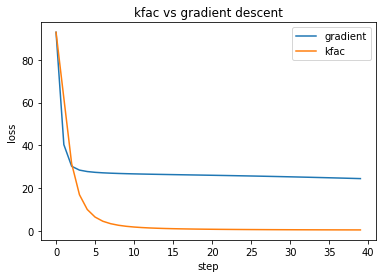

In [9]:
plt.plot(range(40), losses0, label='gradient')
plt.plot(range(40), losses1, label='kfac')
plt.xlabel('step')
plt.ylabel('loss')
plt.title('kfac vs gradient descent')
plt.legend()
plt.show()